In [5]:
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 1. Load the CSV
df = pd.read_csv("global_inflation_data.csv")

# 2. Drop non-numeric columns
# Your first two columns are: country_name and indicator_name
data = df.drop(columns=["country_name", "indicator_name"])

# 3. Drop rows with too few values (optional)
data = data.dropna(thresh=20)

# 4. Fill missing values
data = data.fillna(method="ffill", axis=1).fillna(method="bfill", axis=1)

# 5. Ensure all columns are treated as strings for filtering
data.columns = data.columns.astype(str)

# 6. Get all year columns
year_cols = [col for col in data.columns if col.isdigit()]

# 7. Set up features (X) and target (y)
X = data[year_cols[:-1]]  # all years except last
y = data[year_cols[-1]]   # last year (e.g., 2023)

# 8. Define base regressors
base_learners = [
    ("lr", LinearRegression()),
    ("ridge", Ridge()),
    ("rf", RandomForestRegressor(n_estimators=100, random_state=42))
]

# 9. Meta-model
meta_model = LinearRegression()

# 10. Stacking Regressor
stacked_model = StackingRegressor(estimators=base_learners, final_estimator=meta_model)

# 11. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# 12. Train the model
stacked_model.fit(X_train, y_train)

# 13. Predict and evaluate
y_pred = stacked_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print(f"✅ Mean Squared Error on test set: {mse:.2f}")


C:\Users\tanvi\AppData\Local\Temp\ipykernel_14072\4030584098.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method="ffill", axis=1).fillna(method="bfill", axis=1)


✅ Mean Squared Error on test set: 11.41


In [6]:
from sklearn.model_selection import GridSearchCV

# Define base learners
base_learners = [
    ("lr", LinearRegression()),
    ("ridge", Ridge()),
    ("rf", RandomForestRegressor(random_state=42))
]

# Meta model
meta_model = LinearRegression()

# Stacked Model
stacked_model = StackingRegressor(
    estimators=base_learners,
    final_estimator=meta_model,
    passthrough=True # allow stacking original features too
)

# Parameter Grid
param_grid = {
    'ridge__alpha': [0.01, 0.1, 1.0, 10.0],
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [5, 10, None],
}

# GridSearch
grid_search = GridSearchCV(estimator=stacked_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# Train/Test Split (already done before)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Train Grid Search
grid_search.fit(X_train, y_train)

print(f"✅ Best Parameters: {grid_search.best_params_}")
print(f"✅ Best Score (MSE): {-grid_search.best_score_:.2f}")

# Best model
best_model = grid_search.best_estimator_


Fitting 3 folds for each of 36 candidates, totalling 108 fits
✅ Best Parameters: {'rf__max_depth': None, 'rf__n_estimators': 200, 'ridge__alpha': 10.0}
✅ Best Score (MSE): 21544.42


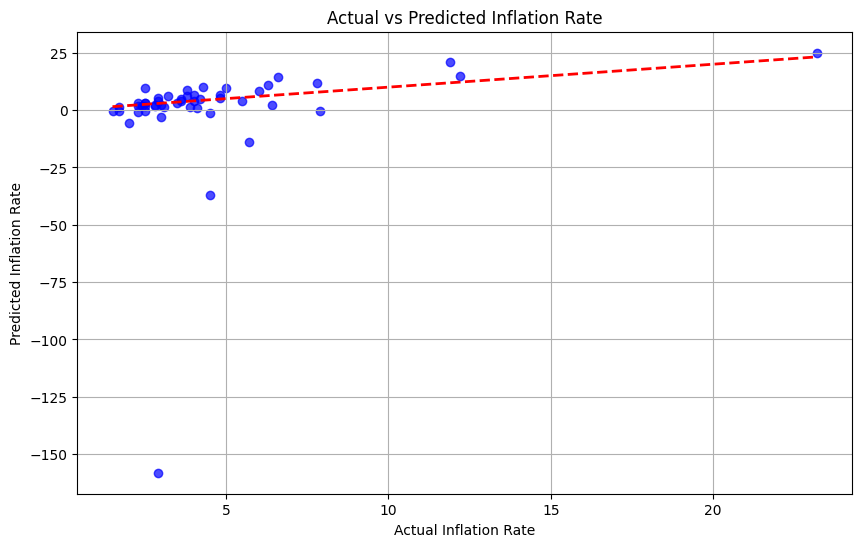

In [7]:
import matplotlib.pyplot as plt

# Predict using the best model
y_pred = best_model.predict(X_test)

# Plot
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel('Actual Inflation Rate')
plt.ylabel('Predicted Inflation Rate')
plt.title('Actual vs Predicted Inflation Rate')
plt.grid(True)
plt.show()
